In [ ]:
import pandas as pd
import re
import json
import matplotlib.pyplot as plt

In [ ]:
#Read csv data
categories_df=pd.read_csv('/content/exhibitor_categories.csv')
exhibitors_df=pd.read_csv('/content/exhibitors.csv')

Dataset Overview
1. Visitors (visitors.csv)
    *   email: Unique email identifier for visitors.
    *   gender : Visitor Gender
    *   id : Unique registration Id
    *   data: JSON data of answers selected during registration.

2. Answers (answers.csv)
    *   id: Unique identifier for an answer.
    *   questionid: The ID of the question this answer belongs to.
    *   answer: The text of the selected answer.

3. Questions (questions.csv)
    *   questionid: Unique identifier for a question.
    *   questionTypeId : Unique identifier for a question Type
    *   Step Id : Unique identifier for a question Step
    *   question: The text of the question.

4. Exhibitor Categories (exhibitor_categories.csv)
    *   categoryId: Unique identifier for an exhibitor category.
    *   categoryName: Description of the category.

5. Exhibitors (exhibitors.csv)
    *   exhibitorID: Unique identifier for an exhibitor.
    *   Name : Exhibitor Name
    *   MainCategories: Pipe-separated (|) list of categories selected by the exhibitor.


















**Understanding the table relations**

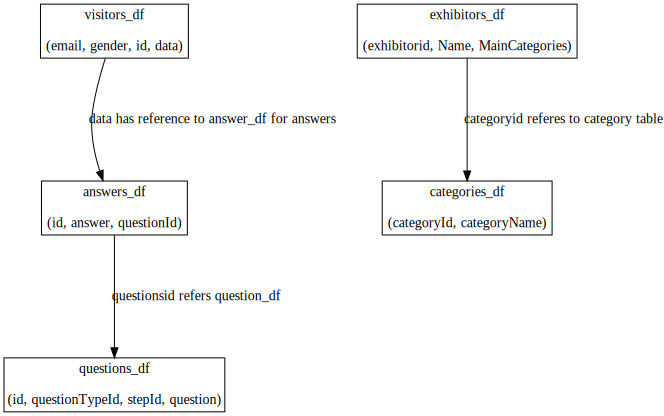

In [ ]:
from graphviz import Digraph

dot = Digraph('Enity Relationships Diagram')

#adding nodes
dot.attr(ranksep='1.5', nodesep='1.5')
dot.node('V', 'visitors_df\n\n(email, gender, id, data)', shape='box')
dot.node('A', 'answers_df\n\n(id, answer, questionId)', shape='box')
dot.node('Q', 'questions_df\n\n(id, questionTypeId, stepId, question)', shape='box')
dot.node('C', 'categories_df\n\n(categoryId, categoryName)', shape='box')
dot.node('E', 'exhibitors_df\n\n(exhibitorid, Name, MainCategories)', shape='box')

#adding relations
dot.edge('V', 'A', label='data has reference to answer_df for answers')
dot.edge('A', 'Q', label='questionsid refers question_df')
dot.edge('E', 'C', label='categoryid referes to category table')

dot.render('ERD_with_squares', format='png', view=True)
dot


In [ ]:
exhibitors_df.isnull().sum()

,0
exhibitorid,0
Name,0
MainCategories,0


In [ ]:
categories_df.isnull().sum()

,0
categoryId,0
categoryName,0


Observed there are no missing values, However, category names needs cleaning

In [ ]:
#Cleaning category names to remove digits/space/special characters
def clean_category_dict(category_dict):
    cleaned_category_dict = {}
    for key, value in category_dict.items():

        value = re.sub(r'^\d+(?:\.\d+)?\.?\s+', '', value)
        value = re.sub(r'\s*/\s*', '/', value)
        value = re.sub(r'\&', 'and', value)
        value = value.strip()
        value=value.lower()

        cleaned_category_dict[key] = value

    return cleaned_category_dict

#Convert Maincategories to list
exhibitors_df['MainCategories']=exhibitors_df['MainCategories'].apply(lambda x: x.split('|'))

#cleaning category names
category_dict=dict(zip(categories_df['categoryId'],categories_df['categoryName']))
cleaned_category_dict=clean_category_dict(category_dict)

Merge catgories with exhibitors

In [ ]:
#Merge categories and exhibitors data
exhibitors_df['MainCategories']=exhibitors_df['MainCategories'].apply(lambda cat_list: [cleaned_category_dict.get(int(cat),cat) for cat in cat_list])

In [ ]:
exhibitors_df.head()

,exhibitorid,Name,MainCategories
0,90556,Turkey Travels,"[resort hotel, inbound tour operator, outbound..."
1,92462,Russian Travel Company,"[apartments/residential hotel, mass market tou..."
2,92491,Indian Travel Company,"[apartments/residential hotel, hostel/motel, o..."
3,92492,Asia Tourism,"[hotel/hotel chain/inn, resort hotel, industri..."
4,92493,SriLanka Adventures,"[transfer services, cultural heritage site, in..."


In [ ]:
expanded_exhibitors_df=exhibitors_df.explode('MainCategories')

In [ ]:
expanded_exhibitors_df

,exhibitorid,Name,MainCategories
0,90556,Turkey Travels,resort hotel
0,90556,Turkey Travels,inbound tour operator
0,90556,Turkey Travels,outbound tour operator
1,92462,Russian Travel Company,apartments/residential hotel
1,92462,Russian Travel Company,mass market tour operators
...,...,...,...
34,17729,Sunny Travel Journeys,receptive/ground operator
34,17729,Sunny Travel Journeys,hotel/hotel chain/inn
34,17729,Sunny Travel Journeys,zoo
34,17729,Sunny Travel Journeys,"banking, investments"


In [ ]:
expanded_exhibitors_df.groupby(['exhibitorid','Name'])['MainCategories'].count().sort_values(ascending=False)

,,MainCategories
exhibitorid,Name,
72153,Elite Adventures Holidays,12
21865,Dream Holidays Holidays,11
55311,Sunny Adventures Journeys,11
48028,Prime Adventures Journeys,11
68142,Global Tours Voyages,10
17729,Sunny Travel Journeys,9
97920,Dream Tours Tours,9
15881,Royal Trips Tours,9
74870,Exotic Tours Journeys,8
